# Comorbid or Not Classifier

### Prepare Data

In [1]:
import sys
sys.path.append("..")
import numpy as np
import sklearn as sk
from sklearn.metrics import classification_report
import torch
from torch import nn, cuda
import matplotlib.pyplot as plt
import prepare_data
from prepare_data import DataPreparationContext
from prepare_data import ClassEmbedders
import models
from models import GenericMutliClassifier

In [2]:
classes = {
    1: "not-comorbid",
    2: "comorbid",
}

def embedder(diseases, classes, classes_lookup):
    if len(diseases) == 0:
        return None
    elif len(diseases) == 1:
        return 1
    else:
        return 2
    
data_context = DataPreparationContext(combine_riskiest=16, verbose=True, classes=classes, class_embedder=embedder)

training_data = data_context.prepare_from_file("../../symptom_sum_top16/train.pkl", oversample=True)
X_train_np = training_data['X']
y_train_np = training_data['y']

validation_data = data_context.prepare_from_file("../../symptom_sum_top16/val.pkl", oversample=False)
X_val_np = validation_data['X']
y_val_np = validation_data['y']



100%|██████████| 21300/21300 [00:02<00:00, 8315.31it/s]


Input File: ../../symptom_sum_top16/train.pkl
 [c o m o r b i d] has 2641
 [n o t - c o m o r b i d] has 2641



100%|██████████| 2662/2662 [00:00<00:00, 8170.29it/s]

Input File: ../../symptom_sum_top16/val.pkl
 [n o t - c o m o r b i d] has 246
 [c o m o r b i d] has 313



## Deep Learning

### Convert to Tensors

In [3]:
X_train = models.convert_to_tensors(X_train_np).type(torch.float32).to(models.device)
y_train = models.convert_to_tensors(y_train_np).type(torch.LongTensor).to(models.device)
X_val = models.convert_to_tensors(X_val_np).type(torch.float32).to(models.device)
y_val = models.convert_to_tensors(y_val_np).type(torch.LongTensor).to(models.device)

### Define Model

The models used are based on tutorial:
```
Bourke , D 2022, PyTorch for Deep Learning & Machine Learning – Full Course, in freeCodeCamp.org (ed.), YouTube, viewed 6 May 2024, <https://www.youtube.com/watch?v=V_xro1bcAuA>.
```

### Train Model

              precision    recall  f1-score   support

not-comorbid       0.53      0.70      0.60       246
    comorbid       0.69      0.52      0.59       313

    accuracy                           0.60       559
   macro avg       0.61      0.61      0.60       559
weighted avg       0.62      0.60      0.60       559



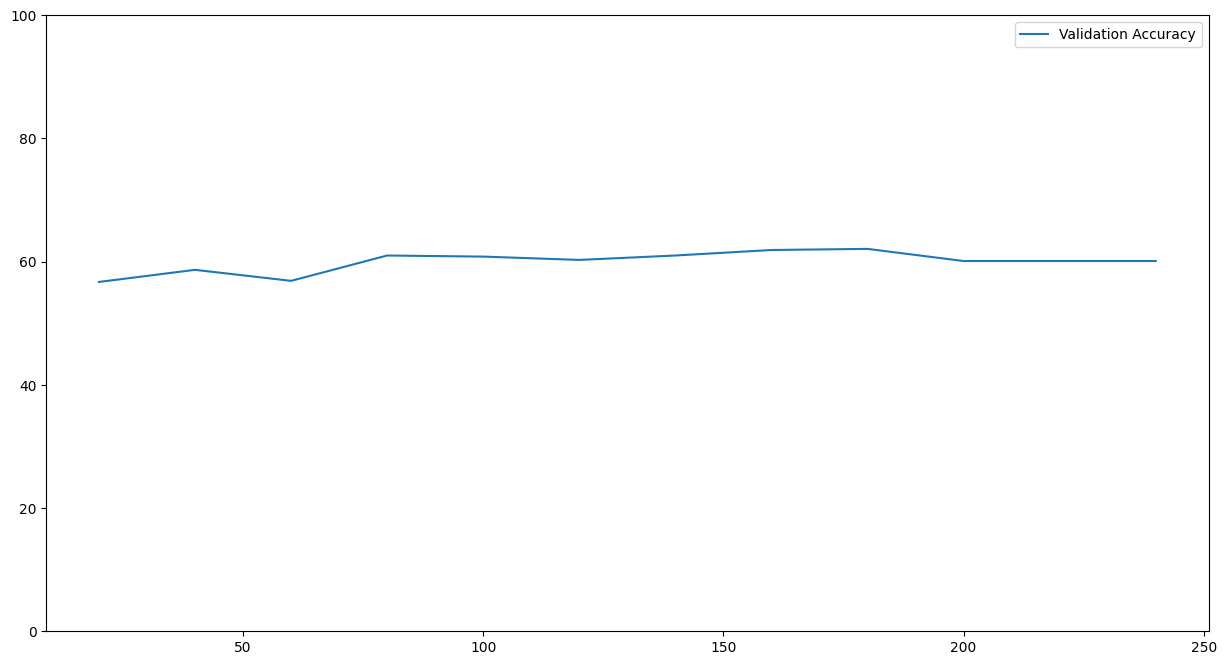

In [8]:
models.begin_plot()

hidden_layers = 250
epochs = 250
learning_rate = 0.0001
labels = classes.values()

model = models.GenericMutliClassifier(input_features=X_train.shape[1], output_features=8, hidden_units=hidden_layers, report_labels=labels).to(models.device)
report = model.train_model(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=epochs,
    learning_rate=learning_rate,
    should_print=True,
    should_plot=True,
    plot_label="Validation Accuracy",
    analysis_interval=20
)
print(report)
models.finish_plot()


### Save Model

In [14]:
model.save_model("2-comorbid-or-not-multiclassifier.pth")